Mounted at /content/drive
✅ Data Shapes → Train: (188, 15), Val: (47, 15), Test: (59, 15)
Fitting 5 folds for each of 65 candidates, totalling 325 fits

== Validation Set ==
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        23
           1       0.96      0.96      0.96        24

    accuracy                           0.96        47
   macro avg       0.96      0.96      0.96        47
weighted avg       0.96      0.96      0.96        47

AUC: 0.9982
Accuracy: 0.9574


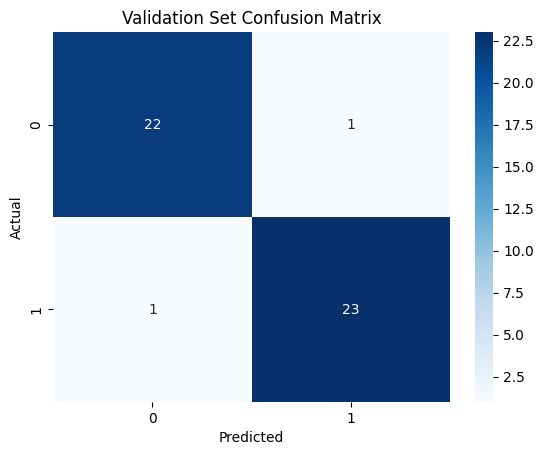


== Test Set ==
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        29

    accuracy                           1.00        59
   macro avg       1.00      1.00      1.00        59
weighted avg       1.00      1.00      1.00        59

AUC: 1.0000
Accuracy: 1.0000


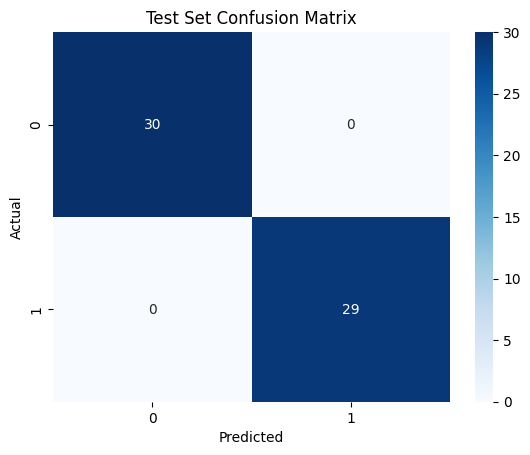

✅ Stacked model saved to: /content/drive/MyDrive/Datasets/Parkinsons_voice/parkinsons_voice_model_stacked.pkl


['/content/drive/MyDrive/Datasets/Parkinsons_voice/voice_rfe.pkl']

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# 3. Paths
data_path = "/content/drive/MyDrive/Datasets/Parkinsons_voice/voice.data"
model_path = "/content/drive/MyDrive/Datasets/Parkinsons_voice/parkinsons_voice_model_stacked.pkl"

# 4. Load and Preprocess Dataset
df = pd.read_csv(data_path)
df.drop("name", axis=1, inplace=True)

X = df.drop("status", axis=1)
y = df["status"]

# 5. Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Apply SMOTE for class balance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# 7. Generate Polynomial (interaction-only) Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_resampled)

# 8. Feature Selection with RFE (top 15)
rfe_selector = RFE(estimator=XGBClassifier(eval_metric='logloss'), n_features_to_select=15)
X_rfe = rfe_selector.fit_transform(X_poly, y_resampled)

# 9. Train/Validation/Test Split
X_temp, X_test, y_temp, y_test = train_test_split(X_rfe, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

print(f"✅ Data Shapes → Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# 10. Hyperparameter Tuning for XGBoost
param_grid = {
    'n_estimators': [100, 300, 500, 800],
    'max_depth': [3, 5, 7, 10, 12],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

search = RandomizedSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    param_distributions=param_grid,
    n_iter=65,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=2
)

search.fit(X_train, y_train)
best_xgb = search.best_estimator_

# 11. Define Base Models for Stacking
rf = RandomForestClassifier(n_estimators=300, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)

# 12. Build and Train StackingClassifier
stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', best_xgb),
        ('rf', rf),
        ('lr', lr)
    ],
    final_estimator=XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, eval_metric='logloss'),
    passthrough=True,
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)

# 13. Evaluation Function
def evaluate(name, model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    print(f"\n== {name} ==")
    print(classification_report(y, y_pred))
    print(f"AUC: {roc_auc_score(y, y_proba):.4f}")
    print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# 14. Final Evaluation
evaluate("Validation Set", stacking_clf, X_val, y_val)
evaluate("Test Set", stacking_clf, X_test, y_test)

# 15. Save Model
joblib.dump(stacking_clf, model_path)
print(f"✅ Stacked model saved to: {model_path}")
# Save preprocessing objects
joblib.dump(scaler, "/content/drive/MyDrive/Datasets/Parkinsons_voice/voice_scaler.pkl")
joblib.dump(poly, "/content/drive/MyDrive/Datasets/Parkinsons_voice/voice_poly.pkl")
joblib.dump(rfe_selector, "/content/drive/MyDrive/Datasets/Parkinsons_voice/voice_rfe.pkl")